# 8 Faces Competition

In [31]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import numpy as np
from sklearn.metrics import confusion_matrix
from keras.utils.vis_utils import model_to_dot

import time
import tensorflow as tf
tf.set_random_seed(1)

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D, Flatten
import keras
import sys
print ("Keras {} TF {} Python {}".format(keras.__version__, tf.__version__, sys.version_info))

Keras 2.1.4 TF 1.2.1 Python sys.version_info(major=3, minor=6, micro=4, releaselevel='final', serial=0)


#### loading data

In [32]:
# Downloading the data, if it does not exist, this will take some time... (>120MB)
import urllib
import os
if not os.path.isfile('8_faces_train_and_valid.hdf5'):
    urllib.request.urlretrieve(
    "https://www.dropbox.com/s/dx03vk6dmbtoywn/8_faces_train_and_valid.hdf5?dl=1",
    "8_faces_train_and_valid.hdf5")

In [33]:
import h5py

h5f_X = h5py.File('8_faces_train_and_valid.hdf5', 'r')
print(list(h5f_X.keys()))
X_train = h5f_X['X_train_8_faces']
print(X_train.shape)
Y_train_raw = h5f_X['Y_train_8_faces']
print(Y_train_raw.shape)
X_valid = h5f_X['X_valid_8_faces']
print(X_valid.shape)
Y_valid_raw = h5f_X['Y_valid_8_faces']
print(Y_valid_raw.shape)

class_labels = ["0 - Miranda Cosgrove", "1 - Chris Martin", "2 - Emma Stone", 
               "3 - Jamie Foxx", "4 - Steve Jobs", "5 - Zac Efron", "6 - Sandra Oh",
               "7 - Taryn Manning"]



['X_train_8_faces', 'X_valid_8_faces', 'Y_train_8_faces', 'Y_valid_8_faces']
(2000, 48, 48, 3)
(2000,)
(400, 48, 48, 3)
(400,)


#### show random picture

1 - Chris Martin


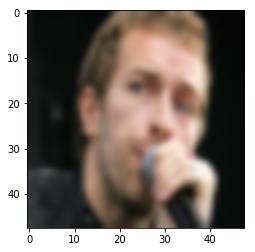

In [34]:
rmd=np.random.randint(0,len(X_train))
plt.imshow(np.asarray(X_train[rmd],dtype="uint8"),interpolation="bicubic")
print(class_labels[Y_train_raw[rmd]])

## data preparation
#### normalization

In [35]:
X_mean = np.mean( X_train, axis = 0)
X_std = np.std( X_train, axis = 0)

X_train = (X_train - X_mean ) / (X_std + 0.0001)
X_valid = (X_valid - X_mean ) / (X_std + 0.0001)

#### one-hot encoding

In [36]:
def convertToOneHot(vector, num_classes=None):
    result = np.zeros((len(vector), num_classes), dtype='int32')
    result[np.arange(len(vector)), vector] = 1
    return result

Y_train=convertToOneHot(Y_train_raw,num_classes=8)
Y_valid=convertToOneHot(Y_valid_raw,num_classes=8)

print(Y_train[13])
print(Y_valid[13])

[0 0 0 0 1 0 0 0]
[0 1 0 0 0 0 0 0]


#### Image Data Generator

In [37]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.0,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

valid_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, Y_train)
valid_generator = valid_datagen.flow(X_valid, Y_valid)

## Define Network
#### Layers

In [24]:
model = Sequential()
name = '5CL_dropout_Datagen'

# Convolutional Part
model.add(Convolution2D(32, (3,3), padding='same', input_shape=(48, 48, 3)))
model.add(Activation("relu"))

model.add(Convolution2D(32, (3,3), padding='same'))
model.add(Activation("relu"))

model.add(Convolution2D(32, (3,3)), padding='same')
model.add(Activation("relu"))

model.add(MaxPooling2D((2,2), 2))
model.add(Dropout(0.3))

model.add(Convolution2D(64, (3,3)))
#model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Convolution2D(64, (3,3)))
#model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D((2,2), 2))
model.add(Dropout(0.3))

model.add(Convolution2D(64, (3,3)))
#model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Convolution2D(64, (3,3)))
#model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D((2,2), 2))
model.add(Dropout(0.3))

# Dense Part
model.add(Flatten())

model.add(Dense(80))
model.add(Dropout(0.3))
model.add(Activation("relu"))

model.add(Dense(40))
model.add(Dropout(0.3))
model.add(Activation("relu"))
#model.add(BatchNormalization())

# Output Layer
model.add(Dense(8))
model.add(Activation("softmax"))

model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])
            

#### Summary

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 46, 46, 32)        896       
_________________________________________________________________
activation_14 (Activation)   (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 44, 44, 32)        9248      
_________________________________________________________________
activation_15 (Activation)   (None, 44, 44, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 20, 20, 64)        18496     
__________

## Training

In [26]:
tensorboard = keras.callbacks.TensorBoard(
        log_dir='tensorboard/faces/' + name + '/', 
        write_graph=True,
        histogram_freq=0)

In [27]:
#save model after every 10 epochs 
savedir = "Checkpoints/8_faces/"+name+"/"
os.makedirs(savedir,exist_ok=True)       
checkpointer = keras.callbacks.ModelCheckpoint( 
        filepath =  savedir+name+"weights_epoch_{epoch:03d}-{val_loss:.2f}.hdf5",
        verbose = 1, 
        save_best_only = False,
        period = 10 )

In [28]:
from livelossplot import PlotLossesKeras

history=model.fit_generator(train_generator, 
                            epochs=50,
                            verbose=2,
                            validation_data=valid_generator,
                            callbacks=[tensorboard, checkpointer])

Epoch 1/50
 - 15s - loss: 2.0830 - acc: 0.1295 - val_loss: 2.0699 - val_acc: 0.1800
Epoch 2/50
 - 15s - loss: 2.0342 - acc: 0.1751 - val_loss: 1.9817 - val_acc: 0.2275
Epoch 3/50
 - 18s - loss: 1.9837 - acc: 0.2083 - val_loss: 2.0432 - val_acc: 0.1775
Epoch 4/50
 - 18s - loss: 1.9465 - acc: 0.2331 - val_loss: 1.9117 - val_acc: 0.2825
Epoch 5/50
 - 18s - loss: 1.9118 - acc: 0.2580 - val_loss: 1.8949 - val_acc: 0.2475
Epoch 6/50
 - 18s - loss: 1.8826 - acc: 0.2803 - val_loss: 1.8007 - val_acc: 0.3325
Epoch 7/50
 - 18s - loss: 1.8217 - acc: 0.3160 - val_loss: 1.7245 - val_acc: 0.3975
Epoch 8/50
 - 18s - loss: 1.7376 - acc: 0.3537 - val_loss: 1.5949 - val_acc: 0.4450
Epoch 9/50
 - 18s - loss: 1.6746 - acc: 0.3874 - val_loss: 1.5080 - val_acc: 0.4700
Epoch 10/50
 - 18s - loss: 1.6224 - acc: 0.4167 - val_loss: 1.4818 - val_acc: 0.5000

Epoch 00010: saving model to Checkpoints/8_faces/4CL_dropout_Datagen/4CL_dropout_Datagenweights_epoch_010-1.48.hdf5
Epoch 11/50
 - 18s - loss: 1.5207 - acc: 0

## Evaluation
#### History

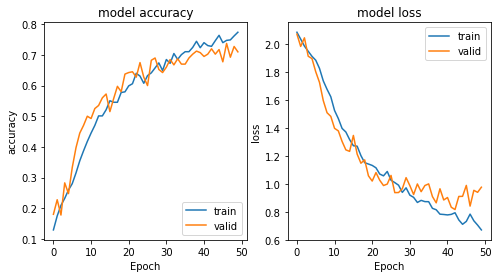

In [29]:
plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1)
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("Epoch")
plt.legend(["train", "valid"], loc="lower right")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("Epoch")
plt.legend(["train", "valid"], loc="upper right")
plt.show()

#### Confusion Matrix

Confusion matrix, without normalization
[[45  1  0  1  0  0  2  1]
 [ 2 14  1 12  3  7  7  4]
 [ 1  0 40  2  0  3  0  4]
 [ 2  2  1 41  1  1  1  1]
 [ 1  4  0  1 43  0  0  1]
 [ 0  1  2  0  0 45  1  1]
 [10  1  0  1  2  1 35  0]
 [ 7  2 13  4  0  1  2 21]]


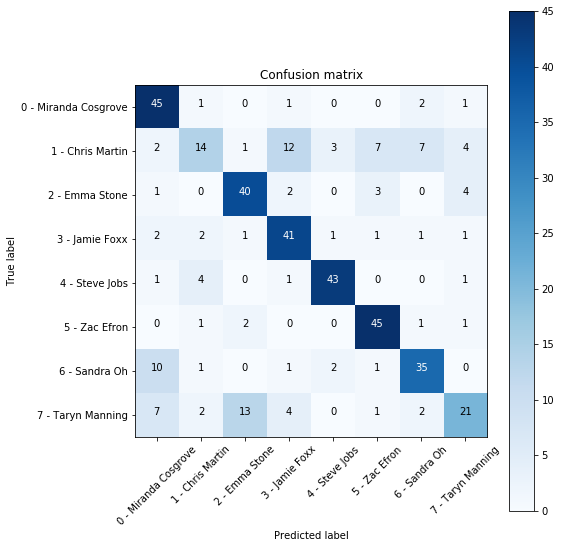

In [30]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


preds_valid = model.predict_classes(X_valid)
cm = confusion_matrix(Y_valid_raw, preds_valid)

# Make Plot
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, class_labels)


In [21]:
del model